# Canny Edge Detection Algoritm And Water Level Indication

## Goal: Implement and Modify Canny Edge Detection Algorithm to Detect Water Level in A Vessel


### Outline of the Canny Edge Detection Algorithm
    1. Noise Reduction
    2. Intesity Gradient Calculation
    3. Non-Maximum Supression
    4. Double Thresholding
    5. Hysteresis Thresholding

### Modifications For Water Level Detection
    Non-Maximum Supression Alteration
    Adhoc Level Line Selection

### Results
    Video of Real-time Level Tracking

## Stage 1: Noise Reduction

#### Goal: Smooth Image to Aid in Gradient Calculation

* A noisy image can be problematic due to the reliance of this algorithm on gradient calculations in subsequent steps.
* 5x5 Gaussian filter like the one we implimented in the homework earlier.
<img src='slide1figs.png'>

In [1]:
'''Import Libraries'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

vidFile = 'Math 7203 Mini Project 1 Video ( 1 min).mp4'
testPNGs = ['IMG02.png','IMG03.png','IMG04.png','IMG05.png',
           'IMG06.png','IMG07.png']

'''Helper Functions For Displaying Images'''
def showAll(img_list):
    '''Plot All the Images Passed in as a List of 
       ndarrays'''
    N_ROWS = 2      # number of rows for display of pics
    R_SIZE = 3      # row cells size
    N_COLS = 3      # number of columns for display of pics
    C_SIZE = 3      # columns cell size
    # Display Images
    plt.figure(figsize=(N_COLS*C_SIZE, N_ROWS*R_SIZE))
    for i,img in enumerate(img_list):
        plt.subplot(N_ROWS, N_COLS, i+1)
        plt.imshow(img, cmap="gray",)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


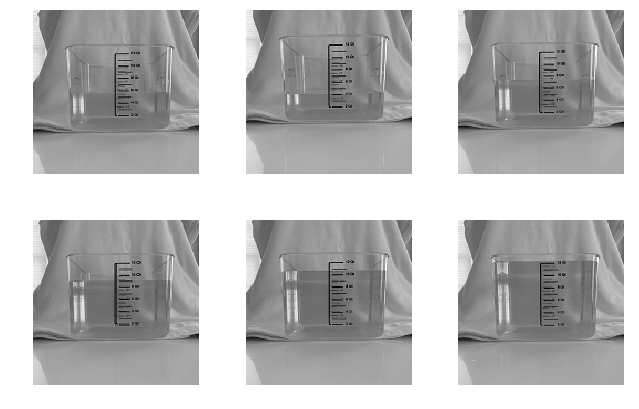

File Numeric Type:  <class 'numpy.uint8'>


In [2]:
'''Read in Files and Display'''
imgs = []       #list to hold raw images

# Read Images
for img in testPNGs:
    imgs.append(cv.imread(img, cv.IMREAD_GRAYSCALE))

# Display images
showAll(imgs)

# display what format the image data is stored in
print('File Numeric Type: ', type(imgs[0][0,0]))

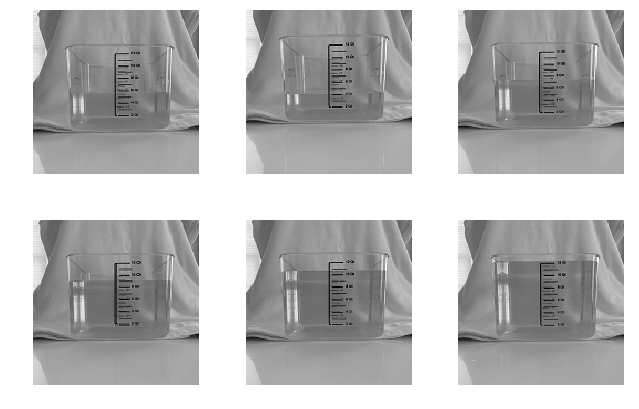

File Numeric Type:  <class 'numpy.uint8'>


In [3]:
'''Filter images And Display Again'''
filtImgs = []   # list to hold filtered images

SIGMA = 0.25     # x-sigma, is copied to y-sigma if y-sigma is not specified
K_SIZE = (5,5)  # Kernel Window Size

# filter images
for img in imgs:
    # Documentation for call from OpenCV Help
    # ...GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])
    filtImgs.append(cv.GaussianBlur(img,K_SIZE,SIGMA,cv.BORDER_REPLICATE))

# Display filtered images
showAll(filtImgs)

# Display what format the image data is stored in
print('File Numeric Type: ', type(filtImgs[0][0,0]))

## Stage 2: Intensity Gradient Calculation
#### Goal: Calculate Magnitude and Angle of Gradient

The edge graident is calculated for the image through use of the Sobel operator and the resulting vectors are stored in angle and magnitude form.  The angle is typically rounded to one of a few selected values to make the following steps easier.
### Sobel Operator
Let $I_{mg}$ be the matrix representing the image file and $SO$ be the Soble Operator, then
\begin{equation}
SO = \begin{pmatrix}1&0&-1\\2&0&-2\\1&0&-1\end{pmatrix}\\
\nabla_x = SO \circledast I_{mg}, \text{and} \nabla_y = SO^T \circledast I_{mg}
\end{equation}
### Intensity Gradient Calculation
Let the Edge Gradient Magnitude $= M$ and the Angle $= \Theta$ then 
\begin{equation}
\boxed{M = \sqrt{\nabla_x^2 + \nabla_y^2}}, \boxed{\Theta = tan^{-1}\Big( \frac{\nabla_y}{\nabla_x} \Big)}
\end{equation}

## Stage 2: Intensity Gradient Calculation...
### Example Calculation No Edge
A uniform window will have all pixels the same value.

\begin{equation}
\nabla_x = I_{mg} \circledast SO = \begin{pmatrix}255&255&255\\255&255&255\\255&255&255\end{pmatrix} \circledast \begin{pmatrix}1&0&-1\\2&0&-2\\1&0&-1\end{pmatrix}  = \begin{pmatrix}255&0&-255\\510&0&-510\\255&0&-255\end{pmatrix} = 0\\
\nabla_y = I_{mg} \circledast SO^T = \begin{pmatrix}255&255&255\\255&255&255\\255&255&255\end{pmatrix} \circledast \begin{pmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{pmatrix}  = \begin{pmatrix}255&510&255\\0&0&0\\-255&-510&-255\end{pmatrix} = 0\\
\Theta = tan^{-1}\Big( \frac{0}{0} \Big) = 0
\end{equation}

## Stage 2: Intensity Gradient Calculation...
### Example Calculation With Vertical Edge
A vertical edge will have a change in pixel values from left to right or right to left. It will have an x gradient but no y.

\begin{equation}
\nabla_x = I_{mg} \circledast SO = \begin{pmatrix}255&0&0\\255&0&0\\255&0&0\end{pmatrix} \circledast \begin{pmatrix}1&0&-1\\2&0&-2\\1&0&-1\end{pmatrix}  \implies \begin{pmatrix}255&0&0\\510&0&0\\255&0&0\end{pmatrix} \implies 1020\\
\nabla_y = I_{mg} \circledast SO^T = \begin{pmatrix}255&0&0\\255&0&0\\255&0&0\end{pmatrix} \circledast \begin{pmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{pmatrix}  \implies \begin{pmatrix}255&0&0\\0&0&0\\-255&0&0\end{pmatrix} \implies 0\\
\Theta = tan^{-1}\Big( \frac{0}{1020} \Big) = 0
\end{equation}

## Stage 2: Intensity Gradient Calculation...
### Example Calculation With Horizontal Edge
A horizontal edge will have a change in pixel values from bottom to top or vise versa. It will have an y gradient but no x.

\begin{equation}
\nabla_x = I_{mg} \circledast SO = \begin{pmatrix}0&0&0\\0&0&0\\255&255&255\end{pmatrix} \circledast \begin{pmatrix}1&0&-1\\2&0&-2\\1&0&-1\end{pmatrix}  \implies \begin{pmatrix}0&0&0\\0&0&0\\255&0&-255\end{pmatrix} \implies 0\\
\nabla_y = I_{mg} \circledast SO^T = \begin{pmatrix}0&0&0\\0&0&0\\255&255&255\end{pmatrix} \circledast \begin{pmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{pmatrix}  \implies \begin{pmatrix}0&0&0\\0&0&0\\-255&-510&-255\end{pmatrix} \implies -1020\\
\Theta = tan^{-1}\Big( \frac{-1020}{0} \Big) = -\pi/2
\end{equation}

## Stage 2: Intensity Gradient Calculation...
### Processed Gradient Images

<img src='intesityGradient.png'>

In [4]:
'''Define function for the Sobel Operator'''

def sobel(A):
    '''Applies 3x3 Sobel Operator to Image Array and 
       returns Magnitude and Angle Arrays '''
    
    # Sobel Operator
    Gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])
    Gy = Gx.T
    
    # Get Dimmensions of kernel and image
    kr,kc = Gx.shape
    r,c = A.shape
    
    # Dimension Output Arrays
    mag = np.zeros((r,c))
    angle = np.zeros((r,c))
    
    
    # Apply Sobel via Convolution
    o_r = kr//2  # offset for rows to center
    o_c = kc//2  # offset for columns to center
    for i in range(r - kr):
        for j in range(c - kc):
            # Perform X and Y Gradient Calcs on Slices of Image
            S1 = np.sum(np.multiply(Gx,A[i:i+kr,j:j+kc]))
            S2 = np.sum(np.multiply(Gy,A[i:i+kr,j:j+kc]))
            
            # Calculate Magnitude and Angle for each pixel
            mag[i+ o_r, j+o_c] = np.sqrt(S1*S1+S2*S2)
            angle[i+ o_r, j+o_c] = np.arctan2(S2,S1)

    return mag, angle


Processing 1 of 6 images....
Processing 2 of 6 images....
Processing 3 of 6 images....
Processing 4 of 6 images....
Processing 5 of 6 images....
Processing 6 of 6 images....
Processing Complete!
=============================== Magnitudes ===============================


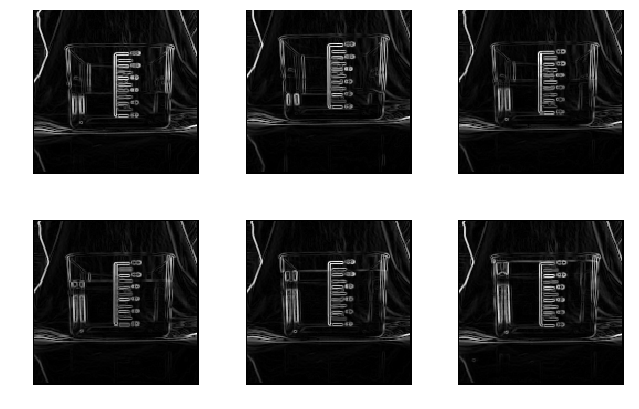

===============================   Angles   ===============================


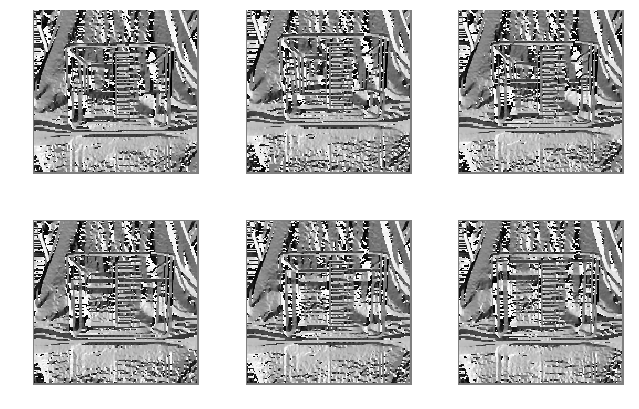

In [5]:
'''Process Images with Sobel Operator and Display'''
mags = []       # list to hold gradient magnitudes
angs = []     # list to hold gradient angles

# Process Filtered Images
N = len(filtImgs)   # Get number of images to process
for i,img in enumerate(filtImgs):
    print('Processing {:d} of {:d} images....'.format(i+1,N))
    m,a = sobel(img)
    mags.append(m)
    angs.append(a)
    
print('Processing Complete!')

# Display Magnitude Images 
print('=============================== Magnitudes ===============================')
showAll(mags)

# Display Angle Images 
print('===============================   Angles   ===============================')
showAll(angs)

## Stage 3: Non-Maximum Supression
#### Goal: Supress Pixels that Are Not a Local Maximum in the Gradient
* Rounded Angles to 0°, 45°, 90°, or 135° reflecting negative angles into quadrant I and II.
* Compare Magnitude of the gradient along Angle to Neighbors.
    * If magnitude larger than its neighbors in the direction of the gradient angle, we leave it alone.
    * Otherwise, we supress the pixel by setting its magnitude to zero.


#### Example
<img src='nonMaxSupress.png'>

In [6]:
def nonMaxSupression(m,a):
    '''Round angle in radians to either 0°, 45°, 90°,
        or 135° and check neighbors in direction of gradient'''
    
    BP1 = 0.3927        # 22.5°
    BP2 = 1.1781        # 67.5°
    BP3 = 1.9635        # 112.5°
    BP4 = 2.7489        # 157.5°    

    s = m.copy()        # copy array 
    r,c = s.shape       # get rows and columns
    
    #loop through image skipping edge pixel
    for i in range(1,r-1):
        # i for rows
        for j in range(1,c-1):
            # j for cols
            
            a1 = np.abs(a[i,j])  # reflect to q 1&2        
            #  classify angles
            if (0<= a1 <BP1) or (BP4<= a1 <=np.pi):
                #closest to x-axis check east to west
                s[i,j] = s[i,j] if \
                (s[i,j-1] < s[i,j] and s[i,j+1] < s[i,j]) else 0         
            elif (BP1<= a1 <BP2):
                # closest to 45° check SW and NE 
                s[i,j] = s[i,j] if \
                (s[i+1,j-1] < s[i,j] and s[i-1,j+1] < s[i,j]) else 0 
            elif (BP2<= a1 <BP3):
                # closest to 90° North and South
                s[i,j] = s[i,j] if \
                (s[i+1,j] < s[i,j] and s[i-1,j] < s[i,j]) else 0
            else:
                # closest to 135° NW and SE
                s[i,j] = s[i,j] if \
                (s[i-1,j-1] < s[i,j] and s[i+1,j+1] < s[i,j]) else 0                
    return s

Processing 1 of 6 images....
Processing 2 of 6 images....
Processing 3 of 6 images....
Processing 4 of 6 images....
Processing 5 of 6 images....
Processing 6 of 6 images....
Processing Complete!


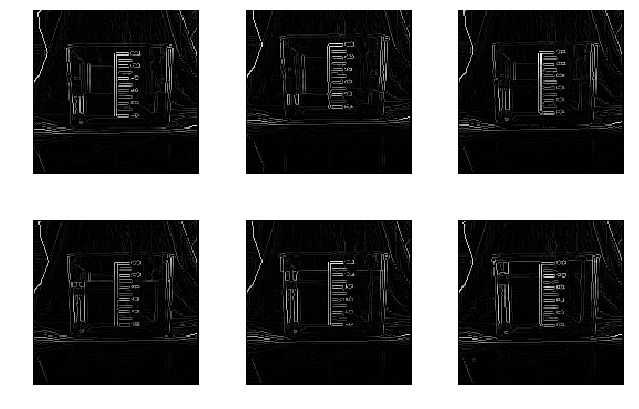

In [7]:
'''Process Images with Non Maximum Supression and Display'''
nms = []

# Process Images
N = len(mags)   # Get number of images to process

for k in range(N):
    print('Processing {:d} of {:d} images....'.format(k+1,N))
    nms.append(nonMaxSupression(mags[k],angs[k]))
    
print('Processing Complete!')

# Display Non-Max Suppressed Images
showAll(nms)


## Stage 4: Double Threshold
#### Goal: Sharpen Boundaries By Classifying Gradient Pixels as Supressed, Weak, or Strong
The continuous nature of leaves many blurred and weak edge boundries.  The double threshold sharpens by applying two thresholds:
* High Threshold-gradient magnitudes above this threshold are encoded as 'strong' edge pixels
* Low Threshold-gradient magnitudes below are suppressed.
* Between High and Low-gradient magnitudes in this range are encoded as 'weak' edge pixels

<img src = 'doubleThresh.png'>

In [8]:
'''Double Threshold Function'''
def dblThreshold(A,H,L):
    '''Suppress Values in image, A, below L and highlight 
        pixel values above H.  Mark those in between as Weak'''
    STRONG = 255
    WEAK = 128
    
    # store shape of A
    r,c = A.shape
    B = np.zeros(r*c)  # create vector with same num pixels
    
    #flatten and cycle through image
    for i,pixel in enumerate(A.reshape(1,-1)[0,:]):
        if pixel > H:
            B[i] = STRONG
        if pixel < H and L < pixel:
            B[i] = WEAK
        # Array was init to zero so
        # no need to check for supression conditions
    return B.reshape(r,c)  

Processing 1 of 6 images....
Processing 2 of 6 images....
Processing 3 of 6 images....
Processing 4 of 6 images....
Processing 5 of 6 images....
Processing 6 of 6 images....
Processing Complete!


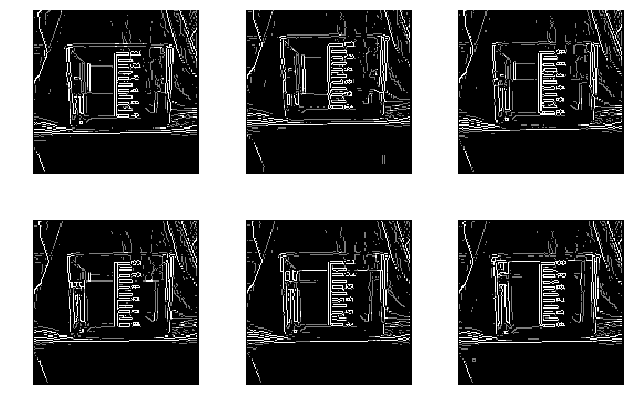

In [9]:
'''Process Images with Double Threshold and Display'''
dblTh = []

HIGH = 110
LOW = 45

# Process Images
N = len(nms)   # Get number of images to process

for k in range(N):
    print('Processing {:d} of {:d} images....'.format(k+1,N))
    dblTh.append(dblThreshold(nms[k],HIGH,LOW))
    
print('Processing Complete!')

# Display Non-Max Suppressed Images
showAll(dblTh)


## Stage 5: Hysteresis Thresholding
#### Goal: Contextually Classify the Weak Pixels as Strong or Supressed
Hysteresis thresholding seeks to classify the weak pixels based on context.
* Sweep from left to right, and top to bottom with a 3x3 window.
* If Last was Strong, mark all Weak pixels as Strong until we reach a Supressed pixel.
* If Last was Surpressed, mark all Weak pixels as Supressed until a Strong pixel is reached
<img src='hysThresh.png'>

In [10]:
'''Define Hysteresis Thresholding Function'''
def hystTresh(A):
    '''Classify pixels as supressed or strong based on neighbors'''
    TOL = 25               # tolerance
    STRONG = 255           # Strong pixel
    WEAK = 128
    SUPRESSED = 0          # Supressed pixel
    WIN = 3                # Window Size of neighbors to check
    
    r,c = A.shape          # Get Shape of A
    B = A.copy()           # Copy A
    
    for i in range(1,r-1):
        # rows loop
        
        for j in range(1,c-1):
            # cols loop
            # check if pixel is weak
            if B[i,j] < WEAK + TOL and B[i,j] > WEAK - TOL:
                #is weak so check neighbors
                if np.max(B[i-1:i+WIN-1,j-1:j+WIN-1]) > STRONG - TOL:
                    B[i,j] = STRONG
                else:
                    B[i,j] = SUPRESSED 
    return B

Processing 1 of 6 images....
Processing 2 of 6 images....
Processing 3 of 6 images....
Processing 4 of 6 images....
Processing 5 of 6 images....
Processing 6 of 6 images....
Processing Complete!


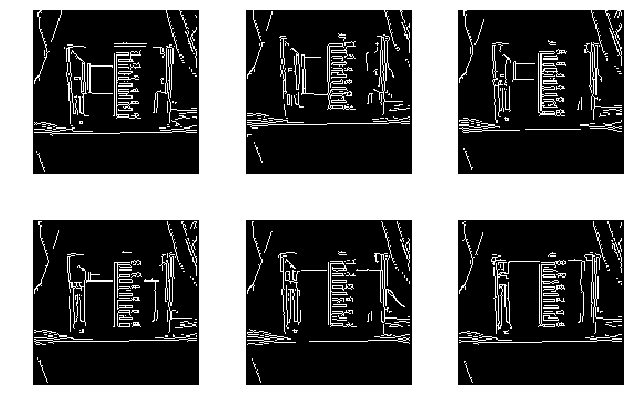

In [11]:
'''Process Images with Double Threshold and Display'''
hys = []

# Process Images
N = len(dblTh)   # Get number of images to process

for k in range(N):
    print('Processing {:d} of {:d} images....'.format(k+1,N))
    hys.append(hystTresh(dblTh[k]))
    
print('Processing Complete!')

# Display Non-Max Suppressed Images
showAll(hys)

## Modifications For Water Level Detection
* __Window The Image__
    * Create a smaller area to process both for speed and to focus on the area where the level is easiest to identify
    
* __Supress All Non-Horizontal Edges (Alter Non-Maximum Supression Stage)__
    * Eliminate all edges that don't have a gradient angle pointing up (90°) (alter the non-maximum supression function)
<img src='gradientAngle.png'>

In [12]:
'''Water Level Finding Funcitons'''

# altered non-maximum supression
def nonHorzSupression(m,a):
    '''Round angle in radians to either 0 or 90°,
    and check neighbors in direction of gradient'''
    
    BP1 = 0.3927        # 22.5°
    BP2 = 1.1781        # 67.5°
    BP3 = 1.9635        # 112.5°
    BP4 = 2.7489        # 157.5°    

    s = m.copy()        # copy array 
    r,c = s.shape       # get rows and columns
    
    #loop through image skipping edge pixel
    for i in range(1,r-1):
        # i for rows
        for j in range(1,c-1):
            # j for cols
            
            a1 = np.abs(a[i,j])  # reflect to q 1&2        
            #  classify angles
            if (BP2<= a1 <BP3):
                # closest to 90° North and South
                s[i,j] = s[i,j] if \
                (s[i+1,j] < s[i,j] and s[i-1,j] < s[i,j]) else 0
            else:
                # not a horizontal line
                s[i,j] = 0                
    return s

# image windowing fucntion
def window(A,dim):
    '''Takes in image, x,y coordinates for start of window and 
       the height (H) and width (W) of the window.  dim = (x,y,H,W)
       Returns pixels in window'''
    x,y,H,W = dim # break out dimensions for clarity
    return A[y:y+H,x:x+W]


Processing 1 of 6 images....
Processing 2 of 6 images....
Processing 3 of 6 images....
Processing 4 of 6 images....
Processing 5 of 6 images....
Processing 6 of 6 images....
Processing Complete!


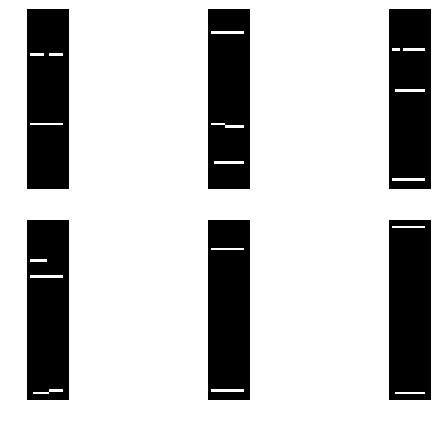

In [13]:
#Filter Constants
SIGMA = .5     # x-sigma, is copied to y-sigma if y-sigma is not specified
K_SIZE = (5,5)  # Kernel Window Size

# Window Constants
X,Y = 55,35
H,W = 65,15
d = (X,Y,H,W)

# Double Thresholding Constants
HIGH = 50
LOW = 10

winEdges = []

# Process Images
N = len(imgs)   # Get number of images to process

for k in range(N):
    print('Processing {:d} of {:d} images....'.format(k+1,N))
    
    # Window Images
    temp = window(imgs[k],d)
    
    # Stage 1 Filter
    temp = cv.GaussianBlur(temp,K_SIZE,SIGMA,cv.BORDER_REPLICATE)
    
    #Stage 2 Gradient
    tempM,tempA = sobel(temp)
    
    # Stage 3 Non Max Supress (modified)
    temp = nonHorzSupression(tempM,tempA)
    
    # Stage 4 Double Thresh
    temp = dblThreshold(temp,HIGH,LOW)
    
    # Stage 5 Hysteresis
    temp = hystTresh(temp)
    
    # Save Results
    winEdges.append(temp)
    
print('Processing Complete!')

# Display Non-Max Suppressed Images
showAll(winEdges)



## Finding the Right Line
#### Goal: Select the Correct Line as the Water Level
#### Ad hoc Algorithm
* Sum up processed windowed segments along the x (rows) axis
* Since we expect the water to be somewhere in the middle, we build a normal gaussian distribution that spans the height of the windowed segment and then use it to weight the elements of the flattened sum matrix
* Argmax of the resulting array should give us the index of the most likely spot for the waterline
<img src='findingTheLine.png'>

In [14]:
def normalDist(L):
    '''return an array of weights corresponding to the 
       length of L centered at L/2'''
    mu = L/2.
    sig = mu/3
    z = (np.linspace(0,L,L) - mu)/sig
    return 1/sig/np.sqrt(2*np.pi)*np.exp(-0.5*z*z)


Processing 1 of 6 images....
Processing 2 of 6 images....
Processing 3 of 6 images....
Processing 4 of 6 images....
Processing 5 of 6 images....
Processing 6 of 6 images....
Processing Complete!


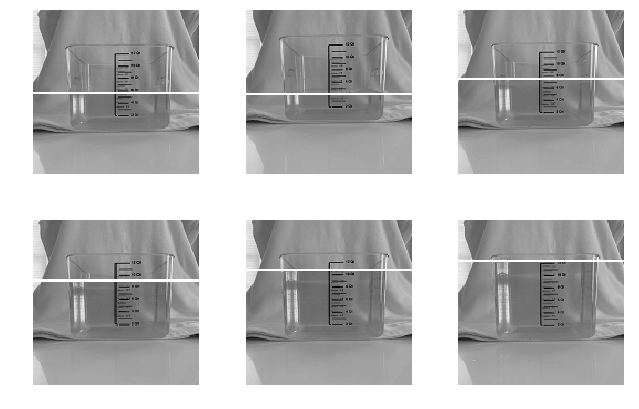

In [15]:
'''Draw Line at Most likely Water level'''
#Constants
LW = 3  # line width to mark up original image

finalImg = []

probCurve = normalDist(H)

# Process Images
N = len(imgs)   # Get number of images to process

for k in range(N):
    print('Processing {:d} of {:d} images....'.format(k+1,N))
    Water = np.argmax(np.multiply(np.sum(winEdges[k],axis=1),probCurve))
    A = imgs[k].copy()
    # Draw line across image
    A[Y+Water-LW//2:Y+Water+LW//2,:] = 255
    finalImg.append(A)
     
print('Processing Complete!')

# Display Non-Max Suppressed Images
showAll(finalImg)

In [16]:
'''Create a waterline detection function'''
def detectLevel(A,win_dim,thresh_HL,filtSK):
    # break out packed parameters for clarity
    X,Y,H,W = win_dim
    sigma,ksize = filtSK
    high,low = thresh_HL
    
    # Window Images
    temp = window(A,win_dim) 
    # Stage 1 Filter
    temp = cv.GaussianBlur(temp,ksize,sigma,cv.BORDER_REPLICATE)
    #Stage 2 Gradient
    tempM,tempA = sobel(temp)
    # Stage 3 Non Max Supress (modified)
    temp = nonHorzSupression(tempM,tempA)
    # Stage 4 Double Thresh
    temp = dblThreshold(temp,high,low)
    # Stage 5 Hysteresis
    temp = hystTresh(temp)
    # Draw final line
    Water = np.argmax(np.multiply(np.sum(temp,axis=1),normalDist(H)))
    # Draw line across image
    A[Y+Water-LW//2:Y+Water+LW//2,:] = 0

    return A

# Results
## Play Real Time Video of Water Draining from Different Vessel and Let Algorithm Track
<img src='realTimeTracking.png'>

In [21]:
#Filter Constants
SIGMA = .5     # x-sigma, is copied to y-sigma if y-sigma is not specified
K_SIZE = (5,5)  # Kernel Window Size

# Window Constants
X,Y = 160,0
H,W = 220,7
d = (X,Y,H,W)

# Double Thresholding Constants
HIGH = 50
LOW = 10

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
# code modified from Help page 
# https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html

cap = cv.VideoCapture(vidFile)
cv.namedWindow('frame',cv.WINDOW_NORMAL)

if not cap.isOpened():
    print('Failed to Open',str(vidFile))
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray = detectLevel(gray,d,(HIGH,LOW),(SIGMA,K_SIZE))
    cv.imshow('frame', gray)
    cv.resizeWindow('frame',800,600)
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

# Canny Edge Detection Algorithm And Water Level Indication

## We Saw...

### General Outline of the Canny Edge Detection Algorithm
    Noise Reduction, Intesity Gradient Calculation, Non-Maximum Supression, 
    Double Thresholding, Hysteresis Thresholding
    
### Modifications Made to the Algorithm to Detect Water Level
    Non-Maximum Supression Alteration, Adhoc Level Line Selection
### Results

# Questions?